<a href="https://colab.research.google.com/github/AV-BOLT/Stars_temp_prediction/blob/master/%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование температуры звезды

В рамках данного проекта нам предлагается решить задачу по предсказанию температуры на поверхности звезды,  по ее характеристикам:

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
Тип звезды.

Целевой признак - Temperature (K).

В нашем распоряжении датасет из 240 изученных звезд.

**Основные шаги:**
- загрузка данных
- анализ и предобработка данных
- построение baseline модели
- улучшение модели (настройка гиперпараметров, обогащение данных и др.)
- оценка итоговой модели.

**Требования:**

При решении данной задачи нам необходимо достичь

- метрика rmse < 4500
- проанализировать модели с разными параметрами dropout, batchsize.

Для решения этой задачи мы построим нейронную сеть следующей архитектуры:

В качестве baseline модели будем использовать нейронную сеть следующей архитектуры:

|  Название параметра |кол-во|  
|---------------|-|
|Входной слой  (нейронов)|3|
|Скрытые слои   |2|
|Выходной слой  (нейронов)|1|
|Инициация весов |xavier_uniform|
|Инициация смещения |constant (0)|
|Функция активации
в выходном слое |nn.ReLU() |

После получения результата baseline модели приступим к улучшению модели, которые можно разделить на 2 метода

Подбор гиперпараметров

- подбор dropout
- подбор batchsize

Обогащение данных

- создание синтетического датасета
- добавление шума к данным.


## Загрузка данных и библиотек

In [ ]:
import pandas as pd
import re
import torch.nn as nn
import torch
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

In [98]:
data = pd.read_csv('/content/drive/MyDrive/Projects_YP/нейронные сети 1 проект/6_class.csv')
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [ ]:
data.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

Названия признаков включают заглавные буквы и различные символы, привидем их к змеиному регистру.

In [ ]:
data = data.drop('Unnamed: 0', axis = 1)
data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [ ]:
# переименуем признаки
data.columns = ['temperature',
                'luminosity',
                'radius',
                'magnitude',
                'star_type',
                'star_color']

Зададим константы для воспроизводимости результатов

In [ ]:
RANDOM_STATE = 42

In [ ]:
torch.manual_seed(RANDOM_STATE)

In [ ]:
np.random.seed(RANDOM_STATE)

In [ ]:
data.columns

Index(['temperature', 'luminosity', 'radius', 'magnitude', 'star_type',
       'star_color'],
      dtype='object')

## Исследовательский анализ

Проверим данные на типы данных и пропущенные значения.

In [ ]:
data.shape

(240, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


В данных отсутствуют пропущенные значения.

Присутствуют числовые и один признак категориальный.




### Анализ категориальных признаков

In [ ]:
categorical = data.select_dtypes(include = 'object').columns.to_list()
categorical

['star_color']

В признаке имеются неявные дубликаты.
Необходимо:
- привести к строчному регистру
- заменить "-" на "_"
- удалить пробелы

In [ ]:
def transform_values(df):

   #удаляем пробелы в конце строк
    df = df.applymap(lambda x: x.rstrip())
     # заменяем пробелы на underscore

    df = df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

    # заменяем дефис на underscore
    df = df.applymap(lambda x: x.replace('-', '_') if isinstance(x, str) else x)

    # добавляем underscore между словом и числом
    df = df.applymap(lambda x: '_'.join(part for part in x.split() if not part.isdigit()) if isinstance(x, str) else x)

    # приводим к строчному регистру
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df

In [ ]:
data[categorical] = transform_values(data[categorical])
data[categorical]

,star_color
0,red
1,red
2,red
3,red
4,red
...,...
235,blue
236,blue
237,white
238,white


In [ ]:
list(data['star_color'].sort_values().unique())

['blue',
 'blue_white',
 'orange',
 'orange_red',
 'pale_yellow_orange',
 'red',
 'white',
 'white_yellow',
 'whitish',
 'yellow_white',
 'yellowish',
 'yellowish_white']

Дубликаты удалены.

In [ ]:
data['star_color'].unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'yellow_white', 'orange',
       'white_yellow', 'yellowish', 'orange_red'], dtype=object)

In [ ]:
data.dtypes

temperature      int64
luminosity     float64
radius         float64
magnitude      float64
star_type        int64
star_color      object
dtype: object

In [ ]:
data[['star_type','star_color' ]].value_counts(normalize = True).to_frame()

0
star_type star_color                  
0         red                 0.166667
1         red                 0.166667
4         blue                0.129167
5         red                 0.095833
3         blue_white          0.087500
2         blue_white          0.058333
          blue                0.054167
4         red                 0.037500
2         white               0.033333
3         yellow_white        0.033333
5         blue                0.029167
          blue_white          0.025000
3         blue                0.020833
2         yellowish_white     0.012500
3         yellowish           0.012500
5         orange              0.008333
          white               0.008333
3         whitish             0.008333
2         white_yellow        0.004167
          pale_yellow_orange  0.004167
3         orange_red          0.004167

### Анализ числовых признаков

In [ ]:
numerical = data.select_dtypes(include = ('int', 'float', 'bool')).columns.to_list()

In [ ]:
numerical =['luminosity', 'radius', 'magnitude', 'star_type']

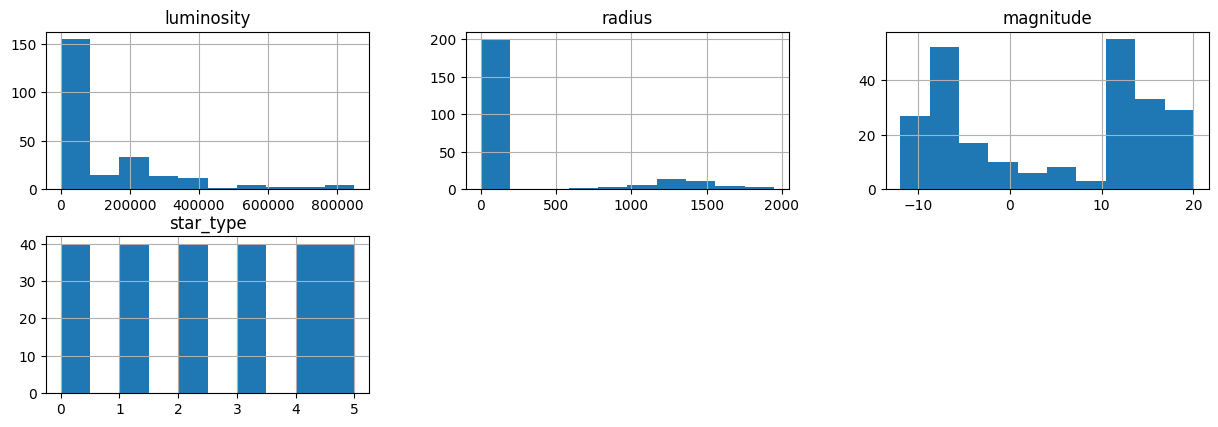

In [ ]:
data[numerical].hist(layout = (4,3),
                     figsize=(15, 10));


Видим, что числовые значения имеют разный порядок, значит необходимо будет перед обучением подготовить признаки.

Вывод:
- Исходный датасет включал в себя 240 наблюдений.
- Пропущенные значения отсутствовали.
- Имелись неявные дубликаты по категории звезд в признке star_color.
- Числовые признаки имеют разный порядок (необходимо масштабировать)
- Имеются категориальные признаки (необходимо перекодировать в числовые).
- Дисбаланса по классам звезд нет, но имеется дисбаланс по цвету звезд.


## Подготовка данных для модели

- Для того, чтобы оценить работу всех моделей, мы создадим список результатов, который заполним названием модели и значением метрика rmse
- Создадим функцию для создания графиков с результатами (согласно исходному заданию)
- Переменные которые одинаковы для всех моделей мы вынесем в раздел подготовки данных

In [ ]:
result = []

In [ ]:
# функция для построения графика для результатов
def plot (y_test, test_outputs, name):

    #name это (название модели)

    fact_values = y_test.numpy().flatten()
    forecast_values = test_outputs.numpy().flatten()

    # в тестовом датасете 48 звезд, но дальше их может быть больше
    # поэтому ограничим
    indexes = test[y].index[:48]

    plt.figure(figsize=(8, 4))
    sns.set_style('ticks', {'axes.grid': True})

    # Создание столбчатой диаграммы для фактических значений
    fact_plot = sns.barplot(x = indexes,
                            y = fact_values,
                            color='blue',
                            alpha=0.9,
                            label='Факт')

    # Создание столбчатой диаграммы для прогнозов
    forecast_plot = sns.barplot(x=indexes,
                                y = forecast_values,
                                color='yellow',
                                alpha=0.7,
                                label='Прогноз')

    # Установка ширины столбцов и их позиции
    bar_width = 0.6

    for bar in fact_plot.patches + forecast_plot.patches:
        bar.set_width(bar_width)
        x = bar.get_x()
        bar.set_x(x + bar_width / 2)

    # Установка подписей осей и заголовка
    plt.xlabel('Номер звезды в таблице данных', fontweight='bold')

    plt.ylabel('Температура звезды', fontweight='bold')

    plt.title(f'{name}')

    plt.xticks(rotation=85)

    plt.yscale('log') # чтобы на графике можно
                       # было увидеть значения разных порядков

    # Создание и настройка легенды
    handles, labels = plt.gca().get_legend_handles_labels()

    handles.reverse()
    labels.reverse()
    plt.legend(handles,
               labels,
               bbox_to_anchor=(0.5, -0.25),
               loc='upper center',
               ncol=2)

    return plt.show()

In [ ]:
# признаки
X = data.drop('temperature', axis = 1).columns.to_list()
y = 'temperature'

In [ ]:
# неизменяемые параметры сети для всех моделей

hidden_neurons = 300

output_neurons = 1

loss = nn.MSELoss()

num_epochs = 15000

In [ ]:
#преобразователь для признаков масштабирование и кодирование категориальных
column_transformer = ColumnTransformer(transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scale', StandardScaler(), numerical)])

## Baseline_model

В качестве baseline модели будем использовать нейронную сеть следующей архитектуры:

|  Название параметра |кол-во|  
|---------------|-|
|Входной слой  (нейронов)|3|
|Скрытые слои   |2|
|Выходной слой  (нейронов)|1|
|Функция активации
в выходном слое |nn.ReLU() |

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self, input_neurons, hidden_neurons, output_neurons):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_neurons, hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, output_neurons)
        self.act2 = nn.ReLU()

        nn.init.normal_(self.fc1.weight, mean=0.5, std=0.5)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.1)  # Изменено с self.act1.bias
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        return x

In [ ]:
#подготовим признаки для обучения
train, valid = train_test_split(data,
                                test_size=0.4,
                                shuffle=True,
                                random_state=RANDOM_STATE)

valid, test = train_test_split(valid,
                               test_size=0.5,
                               shuffle=True,
                               random_state=RANDOM_STATE)

print('Размер обучающей выборки',train.shape)
print( )
print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (144, 6)

Размер валидационной выборки (48, 6)

Размер тестовой выборки (48, 6)


In [ ]:
# для дальнейшей работы нам необходимо будет иметь тот же датасет для предсказаний,
# поэтому сохраним индексы в переменные
valid_index = valid.index
test_index = test.index

In [ ]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print('Oбучающие признаки', X_train.size())
print()
print('Валидационные признаки', X_valid.size())
print()
print('Тестовые признаки', X_test.size())

Oбучающие признаки torch.Size([144, 14])

Валидационные признаки torch.Size([48, 14])

Тестовые признаки torch.Size([48, 14])


In [ ]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):

        outputs = model(X_train)

        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

        if (epoch + 1) % 1000 == 0:
          model.eval()  # Перевести модель в режим оценки
          with torch.no_grad():
              valid_outputs = model(X_valid)
              valid_loss = loss(valid_outputs, y_valid)
              print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')
print(f'Baseline Loss:  {np.sqrt(valid_loss)}')

Epoch [1000/15000], Loss: 20243182.0
Epoch [2000/15000], Loss: 15987445.0
Epoch [3000/15000], Loss: 14741842.0
Epoch [4000/15000], Loss: 14204297.0
Epoch [5000/15000], Loss: 12559491.0
Epoch [6000/15000], Loss: 11460441.0
Epoch [7000/15000], Loss: 10641946.0
Epoch [8000/15000], Loss: 9892805.0
Epoch [9000/15000], Loss: 9234124.0
Epoch [10000/15000], Loss: 8510466.0
Epoch [11000/15000], Loss: 7628477.5
Epoch [12000/15000], Loss: 6622850.5
Epoch [13000/15000], Loss: 5846057.5
Epoch [14000/15000], Loss: 5189825.0
Epoch [15000/15000], Loss: 4591856.0
Baseline Loss:  5266.00341796875


In [ ]:
rmse_baseline = np.sqrt(valid_loss.item())
result.append(['rmse_baseline', rmse_baseline])
result

[['rmse_baseline', 5266.003608050416]]

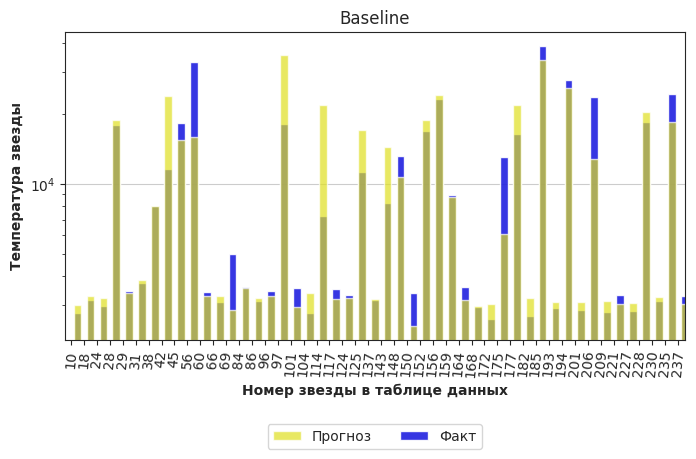

In [ ]:
# строим график для визуализации предсказаний baseline модели
plot(y_valid, valid_outputs, 'Baseline')

Как видно из диаграммы наша модель ошибается на некоторых объектах в сильно большую сторону,  а на других наоборт сильно преуменьшая значения.

## Улучшение модели

В задании к проекту нам дано обязательное требование
создать решение с перебором параметров нейросети:
- dropout
- размер батча.


Следующим этапом я проведу эксперимент с данными:
1.  создам синтетические данные и, обучив на них, получим предсказание на test выборке исходного датасета.
2. аугментирую исходный датасет (добавлю шум к числовым признакам) и, обучив на них, получим предсказание на test выборке исходного датасета.




### Подбор Dropout

In [ ]:
class DropoutModel(nn.Module):
    def __init__(self, input_neurons, hidden_neurons, output_neurons, best_dropout):
        super(DropoutModel, self).__init__()

        self.fc1 = nn.Linear(input_neurons, hidden_neurons)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=best_dropout) # 50% dropout после первого слоя
        self.fc2 = nn.Linear(hidden_neurons, output_neurons)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=best_dropout) # 50% dropout после второго слоя

        nn.init.normal_(self.fc1.weight, mean=0.5, std=0.5)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.1)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)  #  Dropout после первого слоя
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)  #  Dropout после второго слоя

        return x

In [ ]:
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.6]

input_neurons = X_train.shape[1]

dropout_rmse = float('inf')
best_model = None
best_dropout = 0.5

for dropout in dropout_values:
    model = DropoutModel(input_neurons,
                       hidden_neurons,
                       output_neurons,
                       dropout)  # подбираем
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        # Оценка модели на valid данных
            model.eval()  # оценка
            with torch.no_grad():
                valid_outputs = model(X_valid)
                valid_loss = loss(valid_outputs, y_valid)

                # Оценка RMSE на valid данных
                rmse = np.sqrt(valid_loss.item())

            # Сравнение RMSE с лучшим результатом
            if rmse < dropout_rmse:
                dropout_rmse = rmse
                best_model = model
                best_dropout = dropout

Epoch [1000/15000], Loss: 45881104.0
Epoch [2000/15000], Loss: 15961580.0
Epoch [3000/15000], Loss: 14728075.0
Epoch [4000/15000], Loss: 13838714.0
Epoch [5000/15000], Loss: 12191772.0
Epoch [6000/15000], Loss: 11205698.0
Epoch [7000/15000], Loss: 10352991.0
Epoch [8000/15000], Loss: 9631243.0
Epoch [9000/15000], Loss: 9101996.0
Epoch [10000/15000], Loss: 8728012.0
Epoch [11000/15000], Loss: 8229783.0
Epoch [12000/15000], Loss: 7360391.5
Epoch [13000/15000], Loss: 6299230.5
Epoch [14000/15000], Loss: 5564504.5
Epoch [15000/15000], Loss: 4978414.0
Epoch [1000/15000], Loss: 37639772.0
Epoch [2000/15000], Loss: 16204380.0
Epoch [3000/15000], Loss: 14793904.0
Epoch [4000/15000], Loss: 14076156.0
Epoch [5000/15000], Loss: 12243522.0
Epoch [6000/15000], Loss: 11224217.0
Epoch [7000/15000], Loss: 10385982.0
Epoch [8000/15000], Loss: 9590147.0
Epoch [9000/15000], Loss: 8888332.0
Epoch [10000/15000], Loss: 8353896.0
Epoch [11000/15000], Loss: 7759886.0
Epoch [12000/15000], Loss: 6920766.0
Epoch

In [ ]:
print(f'Лучший dropout_rmse: {dropout_rmse}')
print(f'Лучшие параметры: Dropout = {best_dropout}')

Лучший dropout_rmse: 4348.176859328516
Лучшие параметры: Dropout = 0.2


In [ ]:
result.append(['dropout_rmse', dropout_rmse])
result

[['rmse_baseline', 5266.003608050416], ['dropout_rmse', 4348.176859328516]]

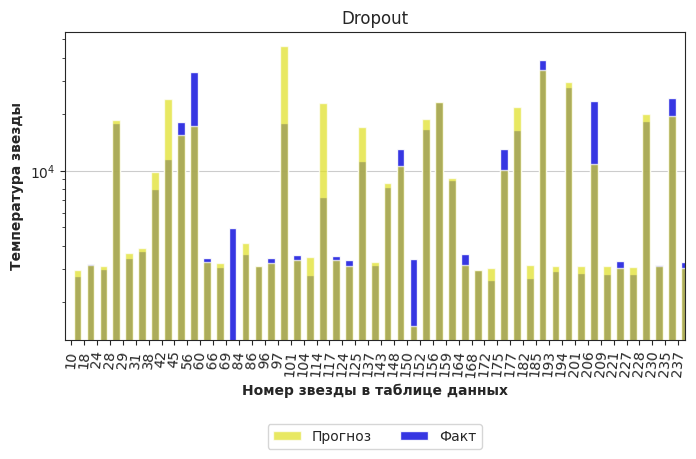

In [ ]:
plot(y_valid, valid_outputs, 'Dropout')

Подбор гиперпараметра dropout позволил нам значительно улучшить метрику примерно на 14%, что позволило нам уже достичь минимально необходимого значения <4500

  ### BatchSize

In [ ]:
batch_sizes = [int(0.1*len(train)),
               int(0.3*len(train)),
               int(0.5*len(train))]

input_neurons = X_train.shape[1]

batch_rmse = float('inf')

best_batch_size = None

for batch_size in batch_sizes:

    # Создание и обучение модели
    model = BaselineModel(input_neurons, hidden_neurons, output_neurons)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            model.eval()
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')
            # Оценка модели на валидационных данных
            with torch.no_grad():
              valid_outputs = model(X_valid)
              valid_loss = loss(valid_outputs, y_valid)
              rmse = np.sqrt(valid_loss.item())

    # Сравнение RMSE с лучшим результатом
    if rmse < batch_rmse:
        batch_rmse = rmse
        best_batch_size = batch_size

print(f'Best Batch Size: {best_batch_size}, Best RMSE: {batch_rmse}')

Epoch [1000/15000], Loss: 20251466.0
Epoch [2000/15000], Loss: 15955332.0
Epoch [3000/15000], Loss: 14689993.0
Epoch [4000/15000], Loss: 14075888.0
Epoch [5000/15000], Loss: 12422564.0
Epoch [6000/15000], Loss: 11253836.0
Epoch [7000/15000], Loss: 10271275.0
Epoch [8000/15000], Loss: 9345365.0
Epoch [9000/15000], Loss: 8613455.0
Epoch [10000/15000], Loss: 8032497.0
Epoch [11000/15000], Loss: 7336013.5
Epoch [12000/15000], Loss: 6624045.5
Epoch [13000/15000], Loss: 6078461.0
Epoch [14000/15000], Loss: 5579526.0
Epoch [15000/15000], Loss: 5129541.0
Epoch [1000/15000], Loss: 20245166.0
Epoch [2000/15000], Loss: 15952692.0
Epoch [3000/15000], Loss: 14744306.0
Epoch [4000/15000], Loss: 14100443.0
Epoch [5000/15000], Loss: 12378628.0
Epoch [6000/15000], Loss: 11181564.0
Epoch [7000/15000], Loss: 10264905.0
Epoch [8000/15000], Loss: 9306709.0
Epoch [9000/15000], Loss: 8662702.0
Epoch [10000/15000], Loss: 8301183.0
Epoch [11000/15000], Loss: 7557146.0
Epoch [12000/15000], Loss: 6875776.5
Epoch

In [ ]:
print(f'Лучший batch_sizes_rmse: {batch_rmse}')
print(f'Лучшие параметры:  Batch Size = {best_batch_size}')

Лучший batch_sizes_rmse: 5454.596593699666
Лучшие параметры:  Batch Size = 43


In [ ]:
result.append(['batch_sizes_rmse', batch_rmse])
result

[['rmse_baseline', 5266.003608050416],
 ['dropout_rmse', 4348.176859328516],
 ['batch_sizes_rmse', 5454.596593699666]]

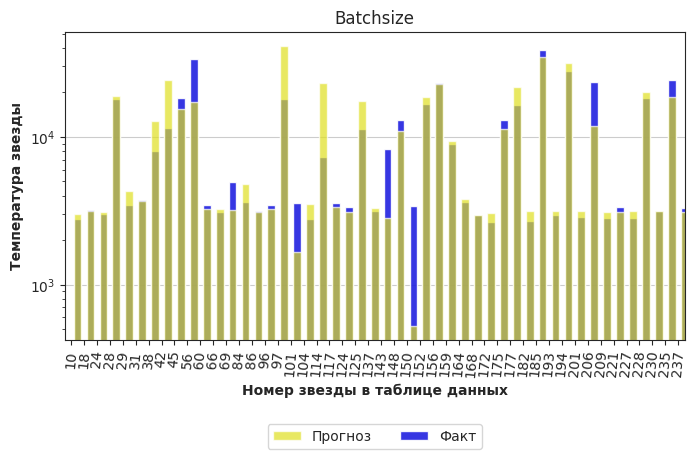

In [ ]:
plot(y_valid, valid_outputs, 'Batchsize')

Видим, что только параметра batchsize недостаточно для достижения требуемой метрики.

### Аугментация данных

Метрику мы будем сравнивать на baseline модели, предсказывая по valid выборке исходного датасета.

###Синтетическая Генерация Данных

Ниже приведена таблица с диапазонами характеристик для каждой звезды, мы будем создавать новые данные используя эту таблицу.

| Температура (K) | Светимость (L/Lo) | Радиус (R/Ro) | Абсолютная звёздная величина (Mv) | Тип звезды | Цвет звезды |
|-----------------|-------------------|---------------|------------------------------------|------------|-------------|
| ~2,000 K        | 0.00001% - 0.1%   | 0.1 - 0.7     | Высокая отрицательная              | M (красные карлики) | Красные, оранжевые |
| ~3,500 K        | 1% - 10%           | 0.7 - 1.0     | Низкая отрицательная               | K | Оранжевые, красные |
| Очень высокая  | Очень низкая       | Сравним с Землёй | Высокая отрицательная | Белые карлики | Белые |
| ~5,500 K        | 100%               | 1.0           | 4.83                               | G (похожие на Солнце) | Желтые |
| ~10,000 K - несколько десятков тысяч K | >100 - несколько тысяч | >1 - несколько сотен | Низкая отрицательная | Горячие звёзды | Голубые, белые |
| ~2,000 K - 1,000 K (обычно ниже) | Очень низкая - очень очень низкая | 0.01 - 0.1 (примерно) | Высокая отрицательная | Коричневые карлики | Коричневые |
| Разнообразная  | Очень высокая - низкая | Разнообразный | Разнообразная | Гиганты (разных классов) | Разноцветные |
| Разнообразная  | Очень высокая - низкая | Разнообразный | Разнообразная | Сверхгиганты | Разноцветные |
| ~5,500 K        | Около 100%         | Около 1.0     | 4.83 | Звёзды главной последовательности | Желтые |


In [ ]:
data['star_color'].value_counts(normalize = True)

red                   0.466667
blue                  0.233333
blue_white            0.170833
white                 0.041667
yellow_white          0.033333
yellowish_white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale_yellow_orange    0.004167
white_yellow          0.004167
orange_red            0.004167
Name: star_color, dtype: float64

In [ ]:
synthetic_data = []

n_samples = 200  # Общее количество сэмплов

# Генерация данных для красных карликов (M-тип)
n_samples_m = int(n_samples * 0.45)
temperature_m = np.random.uniform(2000, 3500, n_samples_m)
luminosity_m = np.random.uniform(0.00001, 0.1, n_samples_m)
radius_m = np.random.uniform(0.1, 0.7, n_samples_m)
magnitude_m = np.random.uniform(-11.92, -6.23, n_samples_m)
star_type_m = [0] * n_samples_m  # добавляем тип звезды (0-6)
star_color_m = ['red'] * n_samples_m

# Генерация данных для оранжевых карликов (K-тип)
n_samples_k = int(n_samples * 0.151)
temperature_k = np.random.uniform(3500, 5500, n_samples_k)
luminosity_k = np.random.uniform(0.01, 0.1, n_samples_k)
radius_k = np.random.uniform(0.7, 1.0, n_samples_k)
magnitude_k = np.random.uniform(-6.23, -2, n_samples_k)
star_type_k = [1] * n_samples_k
star_color_k = ['orange'] * n_samples_k

# Генерация данных для белых карликов (группа "Очень высокая")
n_samples_wd = int(n_samples * 0.16)
temperature_wd = np.random.uniform(5500, 6000, n_samples_wd)
luminosity_wd = np.random.uniform(0.99, 1.01, n_samples_wd)
radius_wd = np.random.uniform(0.99, 1.01, n_samples_wd)
magnitude_wd = np.full(n_samples_wd, 4.83)
star_type_wd = [2] * n_samples_wd
star_color_wd = ['white'] * n_samples_wd

# Генерация данных для звёзд главной последовательности (G-тип)
n_samples_g = int(n_samples * 0.09)
temperature_g = np.random.uniform(5500, 5700, n_samples_g)
luminosity_g = np.random.uniform(0.99, 1.01, n_samples_g)
radius_g = np.random.uniform(0.99, 1.01, n_samples_g)
magnitude_g = np.full(n_samples_g, 4.83)
star_type_g = [3] * n_samples_g
star_color_g = ['yellow'] * n_samples_g

# Генерация данных для горячих звёзд
n_samples_hot = int(n_samples * 0.3)
temperature_hot = np.random.uniform(10000, 30000, n_samples_hot)
luminosity_hot = np.random.uniform(100, 3000, n_samples_hot)
radius_hot = np.random.uniform(10, 100, n_samples_hot)
magnitude_hot = np.random.uniform(-11.92, -6.23, n_samples_hot)
star_type_hot = [4] * n_samples_hot
star_color_hot = ['blue'] * n_samples_hot

# Генерация данных для коричневых карликов (L-тип)
n_samples_l = int(n_samples * 0.06)
temperature_l = np.random.uniform(1000, 2000, n_samples_l)
luminosity_l = np.random.uniform(0.00000001, 0.0000001, n_samples_l)
radius_l = np.random.uniform(0.01, 0.1, n_samples_l)
magnitude_l = np.random.uniform(-11.92, -6.23, n_samples_l)
star_type_l = [5] * n_samples_l
star_color_l = ['blue_white'] * n_samples_l

# создаем новый df
synthetic_data = pd.DataFrame({
    'temperature': np.concatenate((temperature_m,
                                   temperature_k,
                                   temperature_wd,
                                   temperature_g,
                                   temperature_hot,
                                   temperature_l)),

    'luminosity': np.concatenate((luminosity_m,
                                  luminosity_k,
                                  luminosity_wd,
                                  luminosity_g,
                                  luminosity_hot,
                                  luminosity_l)),

    'radius': np.concatenate((radius_m,
                              radius_k,
                              radius_wd,
                              radius_g,
                              radius_hot,
                              radius_l)),

    'magnitude': np.concatenate((magnitude_m,
                                 magnitude_k,
                                 magnitude_wd,
                                 magnitude_g,
                                 magnitude_hot,
                                 magnitude_l)),

    'star_type': np.concatenate((star_type_m,
                                 star_type_k,
                                 star_type_wd,
                                 star_type_g,
                                 star_type_hot,
                                 star_type_l)),

    'star_color': np.concatenate((star_color_m,
                                  star_color_k,
                                  star_color_wd,
                                  star_color_g,
                                  star_color_hot,
                                  star_color_l))
})

# перемешиваем
synthetic_data = synthetic_data.sample(frac=1).reset_index(drop=True)

In [ ]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  242 non-null    float64
 1   luminosity   242 non-null    float64
 2   radius       242 non-null    float64
 3   magnitude    242 non-null    float64
 4   star_type    242 non-null    int64  
 5   star_color   242 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 11.5+ KB


In [ ]:
synthetic_data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,242.000000,2.420000e+02,242.000000,242.000000,242.000000
mean,7554.129521,3.815575e+02,14.925576,-5.672395,1.851240
std,7316.880469,7.722637e+02,27.963584,5.793407,1.764854
min,1025.386356,1.177395e-08,0.011170,-11.893644,0.000000
25%,2773.539251,4.121987e-02,0.478978,-9.733268,0.000000
50%,4879.743939,9.135707e-02,0.911082,-8.052190,2.000000
75%,5991.628380,1.009979e+00,1.008847,-3.553468,4.000000
max,29730.304976,2.970885e+03,95.255501,4.830000,5.000000


In [ ]:
data['star_color'].value_counts(normalize = True)

red                   0.466667
blue                  0.233333
blue_white            0.170833
white                 0.041667
yellow_white          0.033333
yellowish_white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale_yellow_orange    0.004167
white_yellow          0.004167
orange_red            0.004167
Name: star_color, dtype: float64

#### модель на синт данных

Оставим в исходном датасете только объекты train выборки, чтобы можно было верно интерпретировать итоговые предсказания.

In [ ]:
np.array(valid_index)

array([176, 109,  15,  79,   9,  82, 233, 120, 192, 142, 115, 190, 224,
        16, 204,  68, 165, 108, 126,  51,   5, 112,  73, 139, 208, 219,
        25, 223, 136,  67,  65,  55, 153,   6, 207,  19,  93,  30,  35,
        75,  12, 212, 127,  95, 111, 113, 161, 186])

In [ ]:
index_drop = np.concatenate([np.array(valid_index), np.array(test_index)])


In [ ]:
data_train = data.drop(index = list(index_drop))

In [ ]:
train = pd.concat([synthetic_data,data_train],ignore_index=True)
valid = valid

In [ ]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())

torch.Size([386, 15])

torch.Size([48, 15])


In [ ]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                      hidden_neurons,
                      output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        model.eval()  # Перевести модель в режим оценки

        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss(valid_outputs, y_valid)

        print(f'Valid Loss: {np.sqrt(valid_loss.item())}')

Epoch [1000/15000], Loss: 17441806.0
Valid Loss: 4707.427322859058
Epoch [2000/15000], Loss: 14221971.0
Valid Loss: 4566.676472008938
Epoch [3000/15000], Loss: 12948821.0
Valid Loss: 4285.005250871928
Epoch [4000/15000], Loss: 12339887.0
Valid Loss: 4105.995129076507
Epoch [5000/15000], Loss: 11943482.0
Valid Loss: 4024.0984083394383
Epoch [6000/15000], Loss: 11635776.0
Valid Loss: 4005.41695707201
Epoch [7000/15000], Loss: 11458361.0
Valid Loss: 4013.5884193574207
Epoch [8000/15000], Loss: 11149125.0
Valid Loss: 4062.653689400562
Epoch [9000/15000], Loss: 10497981.0
Valid Loss: 4157.368879471726
Epoch [10000/15000], Loss: 9963644.0
Valid Loss: 4178.1328365670715
Epoch [11000/15000], Loss: 9276578.0
Valid Loss: 4222.126952141539
Epoch [12000/15000], Loss: 8515475.0
Valid Loss: 4358.566278032261
Epoch [13000/15000], Loss: 7956380.5
Valid Loss: 4557.2300797743355
Epoch [14000/15000], Loss: 7585221.5
Valid Loss: 4871.929597192472
Epoch [15000/15000], Loss: 7280997.0
Valid Loss: 5169.35063

In [ ]:
rmse_synthetic = np.sqrt(valid_loss.item())
result.append(['rmse_synthetic', rmse_synthetic])
result

[['rmse_baseline', 5266.003608050416],
 ['dropout_rmse', 4348.176859328516],
 ['batch_sizes_rmse', 5454.596593699666],
 ['rmse_synthetic', 5169.350636201804]]

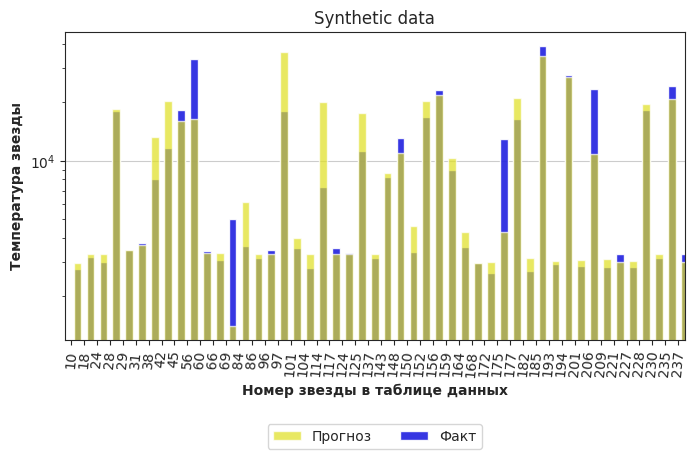

In [ ]:
plot(y_valid, valid_outputs, 'Synthetic data')

### Аугментация данных на основе исходного датасета

In [ ]:
numerical

['luminosity', 'radius', 'magnitude', 'star_type']

In [ ]:
data[numerical].std()

luminosity    179432.244940
radius           517.155763
magnitude         10.532512
star_type          1.711394
dtype: float64

In [ ]:
augmented_data = data.copy()

# числовые признаки, к которым добавляем шум
numeric_features = ['luminosity', 'radius', 'magnitude']

# значения шума
noise_mean = 0  # Среднее значение шума
noise_std = 0.05  # Стандартное отклонение шума

for numeric_feature in numeric_features:
    random_noise = np.random.lognormal(noise_mean, noise_std, len(data))
    augmented_data[numeric_feature] += random_noise

    # контролируем разброс min max значений
    augmented_data[numeric_feature] = np.clip(augmented_data[numeric_feature],
                                              data[numeric_feature].min(),
                                              data[numeric_feature].max())

# Создайте новый DataFrame для аугментированных данных
augmented_data.head()


,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,1.062491,1.202978,17.001363,0,red
1,3042,1.084931,1.086967,17.603203,0,red
2,2600,0.924804,1.060947,19.681586,0,red
3,2800,1.003905,1.186375,17.601595,0,red
4,1939,0.974593,1.146264,20.060000,0,red


In [ ]:
augmented_data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107189.360161,238.156477,5.360943,2.500000
std,9552.425037,179432.228888,517.145030,10.509678,1.711394
min,1939.000000,0.912176,0.905638,-11.028754,0.000000
25%,3344.250000,1.003779,1.122814,-5.245722,1.000000
50%,5776.000000,1.130483,1.783928,9.292616,2.500000
75%,15055.500000,198051.055769,43.751928,14.736283,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [ ]:
data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


####модель на аугментированном датасете с шумом

In [ ]:
train = pd.concat([augmented_data, data_train], ignore_index=True)
valid = valid

In [ ]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)


print(X_train.size())
print()
print(X_valid.size())
print()


torch.Size([384, 16])

torch.Size([48, 16])



In [ ]:
input_neurons = X_train.shape[1]


model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        model.eval()  # Перевести модель в режим оценки
        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss(valid_outputs, y_valid)

print(f'Valid Loss: {np.sqrt(valid_loss.item())}')

Epoch [1000/15000], Loss: 199130944.0
Epoch [2000/15000], Loss: 199130944.0
Epoch [3000/15000], Loss: 199130944.0
Epoch [4000/15000], Loss: 199130944.0
Epoch [5000/15000], Loss: 199130944.0
Epoch [6000/15000], Loss: 199130944.0
Epoch [7000/15000], Loss: 199130944.0
Epoch [8000/15000], Loss: 199130944.0
Epoch [9000/15000], Loss: 199130944.0
Epoch [10000/15000], Loss: 199130944.0
Epoch [11000/15000], Loss: 199130944.0
Epoch [12000/15000], Loss: 199130944.0
Epoch [13000/15000], Loss: 199130944.0
Epoch [14000/15000], Loss: 199130944.0
Epoch [15000/15000], Loss: 199130944.0
Valid Loss: 13002.078603054206


In [ ]:
rmse_augmented = np.sqrt(valid_loss.item())
result.append(['rmse_augmented', rmse_augmented])
result

[['rmse_baseline', 5266.003608050416],
 ['dropout_rmse', 4348.176859328516],
 ['batch_sizes_rmse', 5454.596593699666],
 ['rmse_synthetic', 5169.350636201804],
 ['rmse_augmented', 13002.078603054206]]

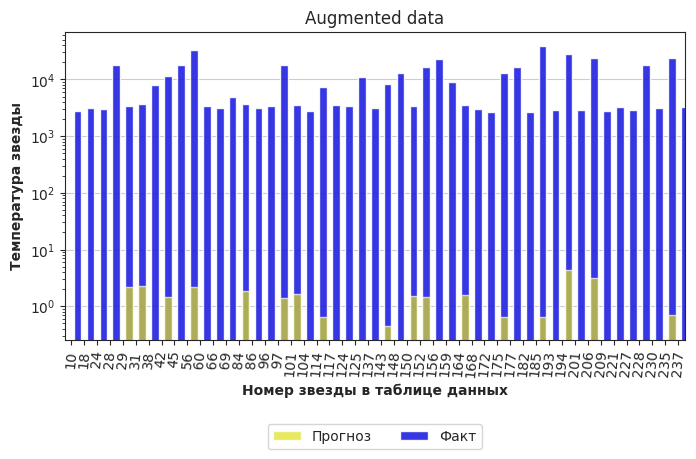

In [ ]:
plot(y_valid, valid_outputs, 'Augmented data')

Судя по результату, я неправильно добавили шум, и модель начала сильно занижать результаты предсказаний

#### Модель на 3-x датасетах

In [ ]:
data_concat = pd.concat([augmented_data,
                          synthetic_data,
                          data_train],
                         ignore_index = True)

In [ ]:
train = data_concat
valid = valid

In [ ]:
print('Размер обучающей выборки',train.shape)
print ()
print('Размер валидационной выборки', valid.shape)

Размер обучающей выборки (626, 6)

Размер валидационной выборки (48, 6)


In [ ]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]).toarray())
X_valid = torch.Tensor(column_transformer.transform(valid[X]).toarray())

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())


torch.Size([626, 17])

torch.Size([48, 17])


In [ ]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        model.eval()  # Перевести модель в режим оценки

        with torch.no_grad():
            valid_outputs = model(X_valid)
            valid_loss = loss(valid_outputs, y_valid)

print(f'Valid Loss: {np.sqrt(valid_loss.item())}')

Epoch [1000/15000], Loss: 21550882.0
Epoch [2000/15000], Loss: 18406390.0
Epoch [3000/15000], Loss: 16637353.0
Epoch [4000/15000], Loss: 15672665.0
Epoch [5000/15000], Loss: 15045223.0
Epoch [6000/15000], Loss: 14578384.0
Epoch [7000/15000], Loss: 14273408.0
Epoch [8000/15000], Loss: 13853846.0
Epoch [9000/15000], Loss: 13096607.0
Epoch [10000/15000], Loss: 11836652.0
Epoch [11000/15000], Loss: 10845557.0
Epoch [12000/15000], Loss: 10353411.0
Epoch [13000/15000], Loss: 10199866.0
Epoch [14000/15000], Loss: 9799399.0
Epoch [15000/15000], Loss: 9182705.0
Valid Loss: 4273.656280048736


In [ ]:
rmse_concat_3df = np.sqrt(valid_loss.item())
result.append(['rmse_concat_3df', rmse_concat_3df])
result

[['rmse_baseline', 5266.003608050416],
 ['dropout_rmse', 4348.176859328516],
 ['batch_sizes_rmse', 5454.596593699666],
 ['rmse_synthetic', 5169.350636201804],
 ['rmse_augmented', 13002.078603054206],
 ['rmse_concat_3df', 4273.656280048736]]

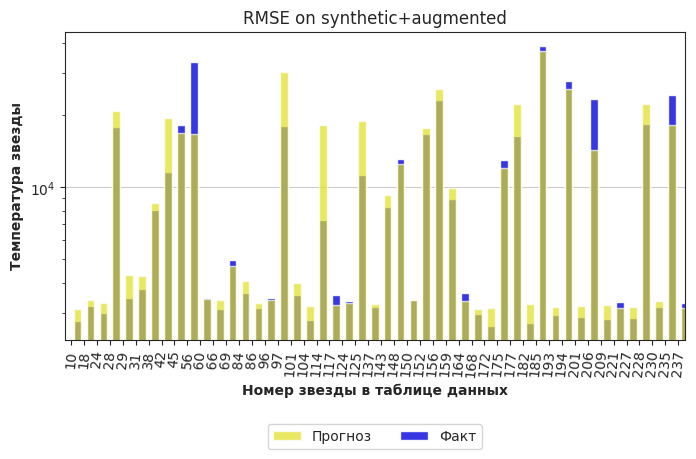

In [ ]:
plot(y_valid, valid_outputs, 'RMSE on synthetic+augmented')

Получились очень интересные наблюдения:

- несмотря на то, что модель на данных с шумом дала сильно хуже результат, на данных созданных из трез датасетов (синтетический, исходный и с шумом) мы получили наилучшую метрику из всех.

Таким образом:
-  мы собрали датасет, который позволяет точнее предсказвать целевой признак\
-  выяснили, что параметр dropout влияет сильнее   на метрику, чем batchsize
- все исследованные гиперпараметры дают снижение метрики.


## Финальная модель

По результатам исследования мы получили данные, что все манипуляции уменьшали rmse модели.

Для получения финальной метрики мы заново осуществим подбор  Dropout и batchsize на объединенном датасете, на котором была получена лучшая метрика.

Учитывая, что датасеты у нас тоже менялись, я найду еще раз лучший размер батча.

In [ ]:
train = data_train

print('Размер обучающей выборки',train.shape)

valid = valid

print('Размер валидационной выборки', valid.shape)

test = test

print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (144, 6)
Размер валидационной выборки (48, 6)
Размер тестовой выборки (48, 6)


In [ ]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())

torch.Size([144, 14])

torch.Size([48, 14])

torch.Size([48, 14])


In [ ]:
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.6]

best_dropout = 0.5

best_model = None

batch_sizes = [int(0.1 * len(X_train)),
               int(0.3 * len(X_train)),
               int(0.5 * len(X_train))]

best_rmse = float('inf')
best_batch_size = None

input_neurons = X_train.shape[1]
#используем модель dropout
model = DropoutModel(input_neurons, hidden_neurons, output_neurons, best_dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for dropout in dropout_values:
    for batch_size in batch_sizes:

        model = DropoutModel(input_neurons, hidden_neurons, output_neurons, dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(num_epochs):
            outputs = model(X_train)
            loss_train = loss(outputs, y_train)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            if (epoch + 1) % 5000 == 0:
                model.eval()
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

                with torch.no_grad():
                    valid_outputs = model(X_valid)
                    valid_loss = loss(valid_outputs, y_valid)
                    rmse = np.sqrt(valid_loss.item())

# лучшие параметры и модель(чтобы сразу оценить на тестовой выборке)
        if rmse < best_rmse:
            best_rmse = rmse
            best_batch_size = batch_size
            best_dropout = dropout
            best_model = model

print(f'Best Batch Size: {best_batch_size}, Best RMSE: {best_rmse}, Best Dropout: {best_dropout}')

Epoch [5000/15000], Loss: 42716984.0
Epoch [10000/15000], Loss: 9080827.0
Epoch [15000/15000], Loss: 5281607.5
Epoch [5000/15000], Loss: 25067592.0
Epoch [10000/15000], Loss: 8900791.0
Epoch [15000/15000], Loss: 4754452.0
Epoch [5000/15000], Loss: 29715888.0
Epoch [10000/15000], Loss: 9182866.0
Epoch [15000/15000], Loss: 5476360.0
Epoch [5000/15000], Loss: 42106616.0
Epoch [10000/15000], Loss: 9283446.0
Epoch [15000/15000], Loss: 6268620.0
Epoch [5000/15000], Loss: 49460044.0
Epoch [10000/15000], Loss: 9161551.0
Epoch [15000/15000], Loss: 5146383.5
Epoch [5000/15000], Loss: 38815756.0
Epoch [10000/15000], Loss: 9138996.0
Epoch [15000/15000], Loss: 5455995.0
Epoch [5000/15000], Loss: 67294368.0
Epoch [10000/15000], Loss: 9500005.0
Epoch [15000/15000], Loss: 5713502.5
Epoch [5000/15000], Loss: 45501296.0
Epoch [10000/15000], Loss: 9463446.0
Epoch [15000/15000], Loss: 5672457.5
Epoch [5000/15000], Loss: 78326832.0
Epoch [10000/15000], Loss: 9528634.0
Epoch [15000/15000], Loss: 6086399.5
E

In [ ]:
print (best_model)

DropoutModel(
  (fc1): Linear(in_features=16, out_features=300, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
)


In [ ]:
best_model.eval()

# Прогон X_test через модель
with torch.no_grad():
    test_outputs = best_model(X_test)
    test_loss = loss(test_outputs, y_test)

# Оценка RMSE (если целевые значения и предсказания имеют одинаковые формы)
rmse_test = np.sqrt(test_loss.item())

print(f'RMSE on Test Data: {rmse_test}')

RMSE on Test Data: 7750.251350762761


In [ ]:
result.append(['rmse_test_on_concated_data', rmse_test])
result

[['rmse_baseline', 5266.003608050416],
 ['dropout_rmse', 4348.176859328516],
 ['batch_sizes_rmse', 5454.596593699666],
 ['rmse_synthetic', 5169.350636201804],
 ['rmse_augmented', 13002.078603054206],
 ['rmse_concat_3df', 4273.656280048736],
 ['rmse_test_on_concated_data', 7750.251350762761]]

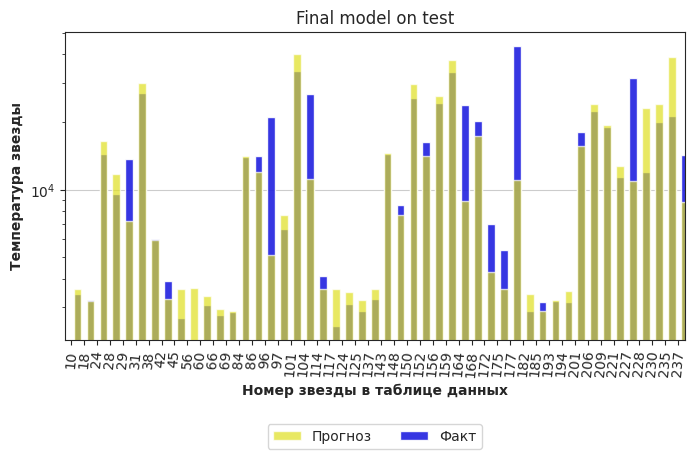

In [ ]:
plot(test_outputs, y_test, 'Final model on test')

Модель переобучена.

In [ ]:
train = data

print('Размер обучающей выборки',train.shape)

valid = valid

print('Размер валидационной выборки', valid.shape)

test = test

print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (240, 6)
Размер валидационной выборки (48, 6)
Размер тестовой выборки (48, 6)


In [ ]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())

torch.Size([240, 16])

torch.Size([48, 16])

torch.Size([48, 16])


In [ ]:
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.6]

best_dropout = 0.5

best_model = None

batch_sizes = [int(0.1 * len(X_train)),
               int(0.3 * len(X_train)),
               int(0.5 * len(X_train))]

best_rmse = float('inf')
best_batch_size = None

input_neurons = X_train.shape[1]
#используем модель dropout
model = DropoutModel(input_neurons, hidden_neurons, output_neurons, best_dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for dropout in dropout_values:
    for batch_size in batch_sizes:

        model = DropoutModel(input_neurons, hidden_neurons, output_neurons, dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for epoch in range(num_epochs):
            outputs = model(X_train)
            loss_train = loss(outputs, y_train)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            if (epoch + 1) % 5000 == 0:
                model.eval()
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

                with torch.no_grad():
                    valid_outputs = model(X_valid)
                    valid_loss = loss(valid_outputs, y_valid)
                    rmse = np.sqrt(valid_loss.item())

# лучшие параметры и модель(чтобы сразу оценить на тестовой выборке)
        if rmse < best_rmse:
            best_rmse = rmse
            best_batch_size = batch_size
            best_dropout = dropout
            best_model = model

print(f'Best Batch Size: {best_batch_size}, Best RMSE: {best_rmse}, Best Dropout: {best_dropout}')

Epoch [5000/15000], Loss: 32074934.0
Epoch [10000/15000], Loss: 14294672.0
Epoch [15000/15000], Loss: 10381174.0
Epoch [5000/15000], Loss: 38137228.0
Epoch [10000/15000], Loss: 14066260.0
Epoch [15000/15000], Loss: 10407846.0
Epoch [5000/15000], Loss: 44017128.0
Epoch [10000/15000], Loss: 13784770.0
Epoch [15000/15000], Loss: 9764906.0
Epoch [5000/15000], Loss: 41547796.0
Epoch [10000/15000], Loss: 14550737.0
Epoch [15000/15000], Loss: 10281897.0
Epoch [5000/15000], Loss: 64913528.0
Epoch [10000/15000], Loss: 14518838.0
Epoch [15000/15000], Loss: 10193040.0
Epoch [5000/15000], Loss: 64881080.0
Epoch [10000/15000], Loss: 14543345.0
Epoch [15000/15000], Loss: 9845102.0
Epoch [5000/15000], Loss: 59690032.0
Epoch [10000/15000], Loss: 14682653.0
Epoch [15000/15000], Loss: 11437490.0
Epoch [5000/15000], Loss: 57915260.0
Epoch [10000/15000], Loss: 14654144.0
Epoch [15000/15000], Loss: 10841876.0
Epoch [5000/15000], Loss: 66678568.0
Epoch [10000/15000], Loss: 14767419.0
Epoch [15000/15000], Lo

In [ ]:
best_model.eval()

# Прогон X_test через модель
with torch.no_grad():
    test_outputs = best_model(X_test)
    test_loss = loss(test_outputs, y_test)

# Оценка RMSE
rmse_test = np.sqrt(test_loss.item())

print(f'RMSE on Test Data: {rmse_test}')

RMSE on Test Data: 3477.98346747077


In [ ]:
result.append(['rmse_final_model', rmse_test])
result

[['rmse_baseline', 5266.003608050416],
 ['dropout_rmse', 4348.176859328516],
 ['batch_sizes_rmse', 5454.596593699666],
 ['rmse_synthetic', 5169.350636201804],
 ['rmse_augmented', 13002.078603054206],
 ['rmse_concat_3df', 4273.656280048736],
 ['rmse_test_on_concated_data', 7750.251350762761],
 ['rmse_final_model', 3477.98346747077]]

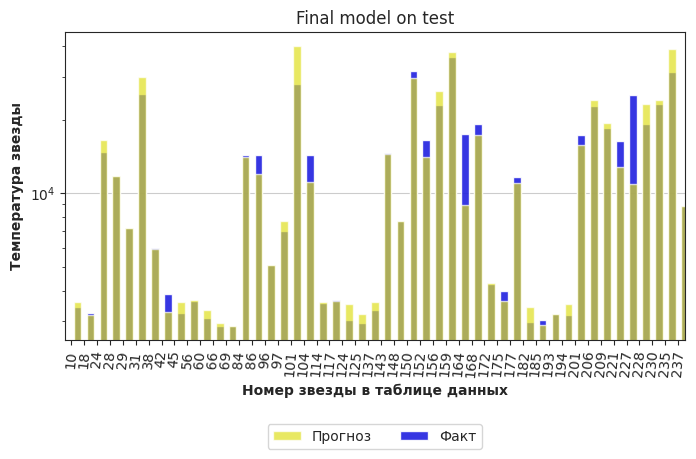

In [ ]:
plot(test_outputs, y_test, 'Final model on test')

In [ ]:
result = pd.DataFrame(data =[result[_][1] for _ in range(len(result))],
                      index = [result[_][0] for _ in range(len(result))])
result

,0
rmse_baseline,5266.003608
dropout_rmse,4348.176859
batch_sizes_rmse,5454.596594
rmse_synthetic,5169.350636
rmse_augmented,13002.078603
rmse_concat_3df,4273.656280
rmse_test_on_concated_data,7750.251351
rmse_final_model,3477.983467


## Вывод

В ходе работы были получены следующие результаты метрики rmse:

|   Модель     |  RMSE        |
|--------------|--------------|
|rmse_baseline |	5266.003608|
|dropout_rmse	 |4348.176859|
|batch_sizes_rmse	|5454.596594|
|rmse_synthetic	 |5169.350636|
|rmse_augmented	 |13002.078603|
|rmse_concat_3df	|4273.656280|
|rmse_test_on_concated_data	|7750.251351|
|rmse_final_model	|3477.983467|


На модели

DropoutModel
  - (fc1): Linear(in_features=16,
  - out_features=300, bias=True)
  - (act1): ReLU()
  - (dropout1): Dropout(p=0.1, inplace=False)
  - (fc2): Linear(in_features=300, out_features=1,  bias=True)
  - (act2): ReLU()
  - (dropout2): Dropout(p=0.1, inplace=False)

Несмотря на то, что была получена низкая метрика на датасете из трех (синтетический, с шумом и исходный) на финальном тестировании метрика оказалась наихудшей из всех моделей, что может говорить о том что модель переобучилась, так как в два раза выше была метрика (4273.6 на валидационном и 7750.2 на тестовой).

В качестве итогового датасета был использован исходный датасет, и была достигнута требуемая метрика.

Обнаружено, что наибольшее влияние на метрику было оказано гиперпаратметром dropout, в то время как параметр batchsize обеспечивал лишь незначительное снижение значения rmse, порядка 3%.